In [1]:
import cv2
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms, ToTensor
from torch.nn import functional as F
import os
import pandas as pd

In [2]:
!pip install d2l
from d2l import torch as d2l

  Obtaining dependency information for d2l from https://files.pythonhosted.org/packages/8b/39/418ef003ed7ec0f2a071e24ec3f58c7b1f179ef44bec5224dcca276876e3/d2l-1.0.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 53.6 MB/s eta 0:00:00
  Obtaining dependency information for matplotlib==3.7.2 from https://files.pythonhosted.org/packages/c2/da/a5622266952ab05dc3995d77689cba600e49ea9d6c51d469c077695cb719/matplotlib-3.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 76.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Attempting uninstall: scipy
    Found existing installation: SciPy 1.11.4
    Un

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
train_transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CustomImageDataset(Dataset):
    def __init__(self, mark_file='', img_dir='', transform=None, target_transform=None, extra_transform = None):
        self.img_labels = pd.read_csv(mark_file, index_col=0) # 训练标注文件
        self.img_dir = img_dir  # 文件目录
        self.transform = transform
        self.target_transform = target_transform
        self.extra_transform = extra_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # image = read_image(img_path)
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]

        #此处修改了
        if 'gray' in self.img_labels.iloc[idx, 0]:
            image = self.extra_transform(image)
        elif self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
 

In [4]:
# 已经读取成train.csv
read_path = r'/kaggle/input/apartofimage/data/train'
dict_mark = {'image':[],'label':[]}
for i in os.listdir(read_path):
    specific_path1 = os.path.join(read_path,str(i))
    categories = int(i)
    for j in os.listdir(specific_path1):
        specific_path2 = os.path.join(specific_path1, str(j))
#         print('categories：', categories,'|path:',specific_path2)
        dict_mark['image'].append(specific_path2)
        dict_mark['label'].append(categories)

pd.DataFrame(dict_mark).to_csv('train.csv')

In [5]:
# 已经读取成train.csv
read_path = r'/kaggle/input/apartofimage/data/test'
dict_mark = {'image':[],'label':[]}
for i in os.listdir(read_path):
    specific_path1 = os.path.join(read_path,str(i))
    categories = int(i)
    for j in os.listdir(specific_path1):
        specific_path2 = os.path.join(specific_path1, str(j))
        dict_mark['image'].append(specific_path2)
        dict_mark['label'].append(categories)

pd.DataFrame(dict_mark).to_csv('test.csv')

### Hybrid

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm
# 创建ResNet模型
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(weights=None)
        # 移除最后的全连接层，以便获取特征
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])

    def forward(self, x):
        return self.resnet(x)

# 创建ViT模型
class ViTModel(nn.Module):
    def __init__(self):
        super(ViTModel, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=False)
    def forward(self, x):
        return self.vit(x)

# 创建混合模型
class HybridModel(nn.Module):
    def __init__(self, resnet_model, vit_model):
        super(HybridModel, self).__init__()
        # 提取ResNet的特征提取部分
        self.resnet_features = resnet_model
        # 提取ViT的特征提取部分
        self.vit_features = vit_model

        # 可以添加一些额外的层进行特征融合等操作
        self.fusion_layer = nn.Linear(in_features=512 + 1000, out_features=100)  # 2048是ResNet的输出通道数，1000是ViT的输出通道数

    def forward(self, x):
        # 使用ResNet提取特征
        resnet_features = self.resnet_features(x)
        # 使用ViT提取特征
        vit_features = self.vit_features(x)

        # 将两个模型的特征进行拼接
        combined_features = torch.cat((resnet_features.view(x.size(0), -1), vit_features.view(x.size(0), -1)), dim=1)

        # 使用融合层进行融合操作
        output = self.fusion_layer(combined_features)

        return output


In [7]:
# 创建ResNet、ViT和混合模型实例
resnet_model = ResNetModel()
vit_model = ViTModel()
hybrid_model = HybridModel(resnet_model, vit_model)

### END

In [8]:
data_font = CustomImageDataset('train.csv', '',train_transformer)
data_train = DataLoader(data_font, batch_size=128, shuffle=True)

In [9]:
data_font1 = CustomImageDataset('test.csv', '',train_transformer)
data_test = DataLoader(data_font1, batch_size=128, shuffle=True)

In [10]:
device = d2l.try_gpu()

training on cuda:0


OutOfMemoryError: CUDA out of memory. Tried to allocate 222.00 MiB (GPU 0; 15.90 GiB total capacity; 14.75 GiB already allocated; 89.75 MiB free; 14.92 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

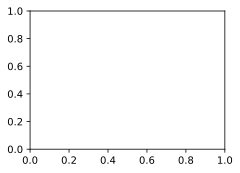

In [11]:
d2l.train_ch6(hybrid_model,data_train,data_test,40,0.08,device)
torch.save(hybrid_model.state_dict() , 'Hybirds_vit224_res.pth' )